# CS549 Machine Learning  
## Assignment 4

**Total: 100 points**
- Section 1: 30 points
- Section 2: 30 points
- Section 3: 40 points

In this assignment, you will implement 1) the forward pass for a basic recurrent neural network, 2) decision tree and ensembles, and 3) k-means algirithm

## Section 1: Character-Level RNN-Based Text Classification Model
In this section, you will implement character-level RNN models that are used to classify the nationality of names.
This is similar to the demo we showed in class :D

This assignment is based on a tutorial from the PyTorch website: <https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html>.
Some helper functions are adopted from the original example. 

The major difference is that you will use the `torch.nn.RNNCell` provided in PyTorch as your basic building block, instead of writing a RNN cell yourself from scratch.

This section includes the following coding tasks:
- Task 1.1 (6 pts): Defining the network
- Task 1.2 (10 pts): Training the model
- Task 1.3 (14 pts): Bi-directional RNN model

## Import packages

In [3]:
import torch
import torch.nn as nn
import random
from rnn2_utils import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

print('num of classes:', n_categories)
print('num of letters:', n_letters)

num of classes: 18
num of letters: 57


## Task 1.1 Defining the network

**6 pts**

Define a single directional RNN model.

**Instructions**
- An RNN cell `rnn_cell`, a fully-connected layer `self.fc`, and a softmax layer `self.softmax` are defined in `__init__()`
- The computational graph is defined in `forward()`. The hidden state of the RNN cell is stored in the tensor `h`, which is of size `[batch_size, hidden_size]`. `forward()` takes as input the tensor `x` in of size `[seq_length, batch_size, input_size]`, whose first dimension is the time steps. Therefore, we use a `for` loop to iterate over the time steps, and for each time step, we feed the input at the current step, and the previous hidden state to the RNN cell. The cell then returns a new hidden state, which overrides `h`.
- Refer to the original tutorial and the API for `nn.RNNCell` for detailed information: https://pytorch.org/docs/stable/nn.html#rnncell.

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        """
        x: size [seq_length, 1, input_size]
        """
        h = torch.zeros(x.size(1), self.hidden_size)
        
        for i in range(x.size(0)):
            ### START YOUR CODE ### 2pts each
            h = self.rnn_cell(x[i], h)
            ### END YOUR CODE ###
        
        ### START YOUR CODE ### 2pts 
        # Hint: first call fc, then call softmax
        mid = self.fc(h)
        out = self.softmax(mid)
        ### END YOUR CODE ###
        
        return out

In [5]:
# Evaluate Task 1.1
### DO NOT CHANGE THE CODE BELOW ###
torch.manual_seed(0)
rnn = RNN(10, 20, 18)
input_data = torch.randn(6, 3, 10)

with torch.no_grad():
    out = rnn(input_data)
    
print(out.size())
print(out[0])

torch.Size([3, 18])
tensor([-3.3146, -3.0216, -2.9363, -3.1215, -2.7141, -2.7103, -2.9526, -3.0657,
        -2.9442, -3.0038, -2.6818, -2.7880, -2.9849, -3.1164, -2.5659, -2.5336,
        -2.9586, -2.9764])


**Expected output**
|&nbsp;|&nbsp;|
|--|--|
|torch.Size([3, 18])|
|tensor([-3.3146, -3.0216, -2.9363, -3.1215, -2.7141, -2.7103, -2.9526, -3.0657,|
| -2.9442, -3.0038, -2.6818, -2.7880, -2.9849, -3.1164, -2.5659, -2.5336,|
| -2.9586, -2.9764])|

## Task 1.2 Training the model

**10 pts**

Train the model with stachastic gradient descent. Due to the setting of the origianl tutorrial, one data example is used per iteration, i.e., the mini-batch size is 1.

**Instructions**
- Each training data example contains a name (`x`) and a label indicating its nationality (`y`). 
- The model uses the tensor version of `x` and `y`, i.e., `x_tensor` and `y_tensor`. Here `x_tensor` is of size `[seq_length, 1, input_size]`, in which `input_size` is the total number of letters.
- `x_tensor[0, 0, :]` as the one-hot encoding for the first letter in the string `x`, and so forth for `x_tensor[1, 0, :]` etc.
- The function will output the predicing result every 5000 iterations. You can find a general trend that the prediction is getting more accurate.

In [6]:
def train(model, n_iters = 100000, print_every = 5000, plot_every = 1000, learning_rate = 0.005):
    # Turn on the training model
    model.train()
    
    # Loss and optimizer
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    
    running_loss = 0
    all_losses = []
    
    # Train loop
    start = time.time()
    for i in range(n_iters):
        y, x, y_tensor, x_tensor = randomTrainingExample()
        
        ### START YOUR CODE ###
        # zero grad 2pts
        optimizer.zero_grad()
        
        # Forward pass, 2pts each
        output = model(x_tensor)
        loss = criterion(output, y_tensor)

        # Backprop and update, 2pts each
        loss.backward()
        optimizer.step()
        ### END YOUR CODE ###
        
        # Record loss
        running_loss += loss.item()
        
        # Print iter, loss, name, and guess
        if i % print_every == 0 and i > 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == y else '✗ (%s)' % y
            print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss.item(), x, guess, correct))
        
        # Append loss
        if i % plot_every == 0 and i > 0:
            all_losses.append(running_loss / plot_every)
            running_loss = 0
    
    # Plot
    plt.figure()
    plt.plot(all_losses)

5000 5% (0m 3s) 2.8908 Jacques / Greek ✗ (French)
10000 10% (0m 6s) 1.7356 Mcmahon / Irish ✓
15000 15% (0m 9s) 1.7122 Ferreira / Spanish ✗ (Portuguese)
20000 20% (0m 12s) 2.6051 Finn / Chinese ✗ (Irish)
25000 25% (0m 15s) 2.8467 Arian / Scottish ✗ (Arabic)
30000 30% (0m 18s) 0.0768 Takahama / Japanese ✓
35000 35% (0m 21s) 0.0167 Antimisiaris / Greek ✓
40000 40% (0m 24s) 1.3374 Chlebek / Czech ✗ (Polish)
45000 45% (0m 28s) 1.8558 Robles / Dutch ✗ (Spanish)
50000 50% (0m 31s) 0.4252 OuYang / Chinese ✓
55000 55% (0m 34s) 0.1350 Issa / Arabic ✓
60000 60% (0m 37s) 1.5986 Ton / Korean ✗ (Vietnamese)
65000 65% (0m 41s) 0.4888 Kaibara / Japanese ✓
70000 70% (0m 44s) 2.1008 Cormac / Czech ✗ (Irish)
75000 75% (0m 48s) 0.5329 Waldvogel / German ✓
80000 80% (0m 51s) 0.1877 Azarola / Spanish ✓
85000 85% (0m 54s) 0.6457 Cathan / Irish ✓
90000 90% (0m 57s) 1.6864 Mikhailyants / Dutch ✗ (Russian)
95000 95% (1m 1s) 1.2736 Lauwers / English ✗ (Dutch)


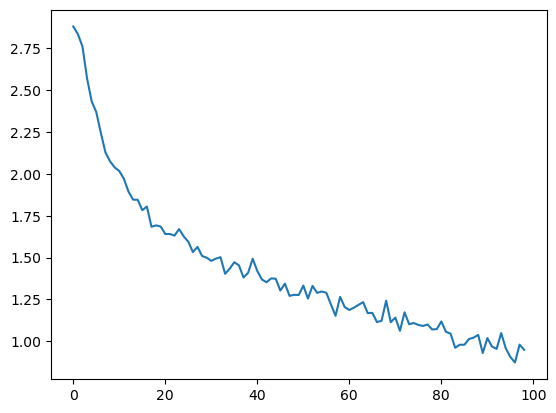

In [7]:
# Evaluate Task 1.2
### DO NOT CHANGE THE CODE BELOW ###
torch.manual_seed(0)
random.seed(0)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

train(rnn)

**Expected output**
|&nbsp;|&nbsp;|
|--|--|
|5000 5% (0m 8s) | 3.1065 Ba / Vietnamese ✗ (Arabic)|
|10000 10% (0m 17s)| 1.9009 Silva / Spanish ✗ (Portuguese)|
|15000 15% (0m 27s)| 0.9776 Salucci / Italian ✓|
|20000 20% (0m 36s)| 1.5460 Chaim / Korean ✗ (Chinese)|
|25000 25% (0m 47s)| 1.9412 Cruz / Spanish ✗ (Portuguese)|
|30000 30% (0m 57s)| 2.6189 Neusser / Dutch ✗ (Czech)|
|35000 35% (1m 8s) |0.4944 Ribeiro / Portuguese ✓|
|40000 40% (1m 18s)| 0.3007 Daher / Arabic ✓|
|45000 45% (1m 28s)| 1.5447 Guang / Vietnamese ✗ (Chinese)|
|50000 50% (1m 38s)| 0.9920 Mackenzie / Scottish ✓|
|55000 55% (1m 48s)| 2.6635 Moon / English ✗ (Korean)|
|60000 60% (1m 59s)| 2.5376 Boutros / Portuguese ✗ (Arabic)|
|65000 65% (2m 9s) |0.5595 Schuttmann / German ✓|
|70000 70% (2m 19s)| 1.6059 Spada / Japanese ✗ (Italian)|
|75000 75% (2m 30s)| 1.1130 Coilean / Irish ✓|
|80000 80% (2m 40s)| 0.6820 Schneider / German ✓|
|85000 85% (2m 50s)| 0.3628 Lopez / Spanish ✓|
|90000 90% (3m 1s) |1.1985 Tremblay / French ✓|
|95000 95% (3m 12s)| 1.0904 Knopf / German ✓|


## Task 1.3 Bi-directional RNN model
**14 pts**

Implement a bi-directional RNN model by modifying the architecture of the `RNN` class.

**Instructions**
- Two distinct RNN cells are defined in `__init__()`. The input size for the fully-connected layer is doubled, because it needs take input the concatenated hidden states from the two cells.
- In `forward()`, two hidden states, `h1` and `h2`, are computed separately. `h1` is exactly the same as the previous `h` in one-directional `RNN`. `h2` is computed by reversing the order of the `for` loop: iterating from the last time step to the first time step.
- Concatenate `h1` and `h2` using `torch.cat()`. Notice that the correct dimension needs be specified. 

In [8]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn_cell1 = nn.RNNCell(input_size, hidden_size)
        self.rnn_cell2 = nn.RNNCell(input_size, hidden_size)
        
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        """
        x: size [seq_length, 1, input_size]
        """
        ### START YOUR CODE ### 2pts each
        h1 = torch.zeros(x.size(1), self.hidden_size)
        for i in range(x.size(0)):
            h1 = self.rnn_cell1(x[i], h1)
        
        h2 = torch.zeros(x.size(1), self.hidden_size)
        for i in reversed(range(x.size(0))): # 2pts each Hint: reverse the order of the for loop
            h2 = self.rnn_cell2(x[i], h2)
        
        h = torch.cat([h1,h2],1)
        out = self.softmax(self.fc(h))
        ### END YOUR CODE ###
        
        return out

5000 5% (0m 5s) 3.1154 Jacques / Greek ✗ (French)
10000 10% (0m 10s) 1.5236 Mcmahon / Scottish ✗ (Irish)
15000 15% (0m 16s) 1.4322 Ferreira / Spanish ✗ (Portuguese)
20000 20% (0m 22s) 2.2772 Finn / Chinese ✗ (Irish)
25000 25% (0m 28s) 1.1499 Arian / Arabic ✓
30000 30% (0m 34s) 0.0653 Takahama / Japanese ✓
35000 35% (0m 40s) 0.0596 Antimisiaris / Greek ✓
40000 40% (0m 45s) 1.3657 Chlebek / Czech ✗ (Polish)
45000 45% (0m 51s) 1.9852 Robles / Dutch ✗ (Spanish)
50000 50% (0m 57s) 0.0468 OuYang / Chinese ✓
55000 55% (1m 2s) 0.0540 Issa / Arabic ✓
60000 60% (1m 8s) 1.5942 Ton / Korean ✗ (Vietnamese)
65000 65% (1m 13s) 0.3659 Kaibara / Japanese ✓
70000 70% (1m 19s) 3.7787 Cormac / French ✗ (Irish)
75000 75% (1m 25s) 1.5433 Waldvogel / Czech ✗ (German)
80000 80% (1m 30s) 0.1893 Azarola / Spanish ✓
85000 85% (1m 36s) 0.4187 Cathan / Irish ✓
90000 90% (1m 41s) 1.6980 Mikhailyants / Greek ✗ (Russian)
95000 95% (1m 47s) 1.6534 Lauwers / English ✗ (Dutch)


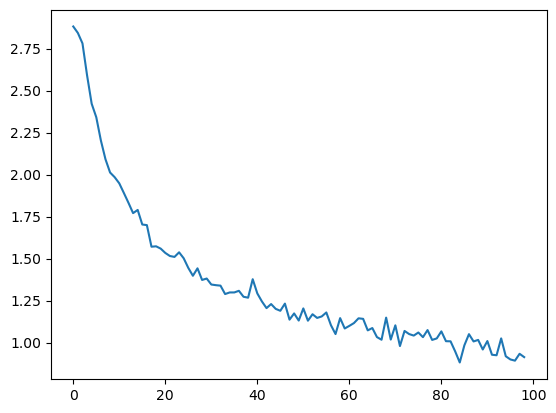

In [9]:
# Evaluate Task 1.3
### DO NOT CHANGE THE CODE BELOW ###
torch.manual_seed(0)
random.seed(0)

n_hidden = 128
birnn = BiRNN(n_letters, n_hidden, n_categories)

train(birnn)

**Expected output**
|&nbsp;|&nbsp;|
|--|--|
|5000 5% (0m 16s) | 2.9060 Ba / Vietnamese ✗ (Arabic)
|10000 10% (0m 33s)| 1.9203 Silva / Spanish ✗ (Portuguese)
|15000 15% (0m 51s)| 0.8597 Salucci / Italian ✓
|20000 20% (1m 10s)| 1.8664 Chaim / Vietnamese ✗ (Chinese)
|25000 25% (1m 29s)| 2.5580 Cruz / Spanish ✗ (Portuguese)
|30000 30% (1m 50s)| 3.2462 Neusser / Dutch ✗ (Czech)
|35000 35% (2m 8s) |0.4040 Ribeiro / Portuguese ✓
|40000 40% (2m 27s)| 0.3474 Daher / Arabic ✓
|45000 45% (2m 45s)| 1.1283 Guang / Vietnamese ✗ (Chinese)
|50000 50% (3m 3s) |1.4291 Mackenzie / Russian ✗ (Scottish)
|55000 55% (3m 20s)| 3.2796 Moon / Scottish ✗ (Korean)
|60000 60% (3m 38s)| 2.5028 Boutros / Portuguese ✗ (Arabic)
|65000 65% (3m 55s)| 0.0673 Schuttmann / German ✓
|70000 70% (4m 13s)| 1.3614 Spada / Italian ✓
|75000 75% (4m 30s)| 0.4321 Coilean / Irish ✓
|80000 80% (4m 47s)| 1.7251 Schneider / Dutch ✗ (German)
|85000 85% (5m 4s) |0.3610 Lopez / Spanish ✓
|90000 90% (5m 22s)| 1.3607 Tremblay / French ✓
|95000 95% (5m 40s)| 1.6964 Knopf / Czech ✗ (German)

Simply from the above output, it seems that BiRNN does not bring significant improvement.
Though we need more systematic evaluation.

# Task for fun! 
Try with the following functions on your own names!

In [10]:
def evaluate(model, x_tensor):
    model.eval()
    with torch.no_grad():
        output = model(x_tensor)
    return output


def predict(model, input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(model, lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [11]:
# replace with your name
predict(birnn, 'Casey')
predict(rnn, 'Casey')

predict(birnn, 'Pascucci')
predict(rnn, 'Pascucci')


> Casey
(-0.54) Arabic
(-1.59) French
(-2.22) Czech

> Casey
(-0.77) Arabic
(-2.18) English
(-2.50) Irish

> Pascucci
(-0.03) Italian
(-4.34) Portuguese
(-4.38) Spanish

> Pascucci
(-0.20) Italian
(-2.52) French
(-2.73) Spanish


## Section 2: Decision tree and ensemble methods
**30 pts**

In this section, you will implement and evaluate a Decision Tree, Bagging, and Random Forest classifier.

If needed, use `!pip install mlxtend` to install the package.

This section includes the following coding tasks:
- Task 2.1 (10 pts):  Run Decision tree classifiers with various parameters
- Task 2.2 (8 pts): Q&A
- Task 2.3 (6 pts): Bagging
- Task 2.4 (6 pts): Random Forest

In [12]:
# Import Required Libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

## Load Data

In [13]:
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = data.feature_names
target_names = data.target_names
print(feature_names)
print(target_names) 

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


## Task 2.1 Decision Tree Implementation
**10pts**

**Instructions**:
1. Implement a tree using "Gini impurity" with a maximum tree depth of 1 (excluding the root node).
2. Implement a tree using only two features (`sepal length (cm)` and `sepal width (cm)`) with "Gini impurity" as the criterion and a maximum tree depth of 3.
3. Implement a tree using "Entropy" with a maximum tree depth of 3.

In [14]:
# 1. Implement a tree using "Gini impurity" with a maximum tree depth of 1 (excluding the root node).
### START YOUR CODE ### 2 pts
dt1 = DecisionTreeClassifier(random_state=42, criterion="gini",max_depth=1)
### END YOUR CODE ###
dt1.fit(X_train, y_train)
y_pred1 = dt1.predict(X_test)

In [15]:
# 2. Implement a tree using only two features (sepal length (cm) and sepal width (cm)) with "Gini impurity" as the criterion and a maximum tree depth of 3.
### START YOUR CODE ### 2pts each
dt2 = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=3)
dt2.fit(X_train[:, :2], y_train)
y_pred2 = dt2.predict(X_test[:, :2])
### END YOUR CODE ###

In [16]:
# 3. Implement a tree using "Entropy" with a maximum tree depth of 3.
### START YOUR CODE ### 2pts
dt3 = DecisionTreeClassifier(random_state=42, criterion="entropy",max_depth=3)
### END YOUR CODE ###
dt3.fit(X_train, y_train)
y_pred3 = dt3.predict(X_test)

Decision Tree #1 Accuracy: 0.7111111111111111


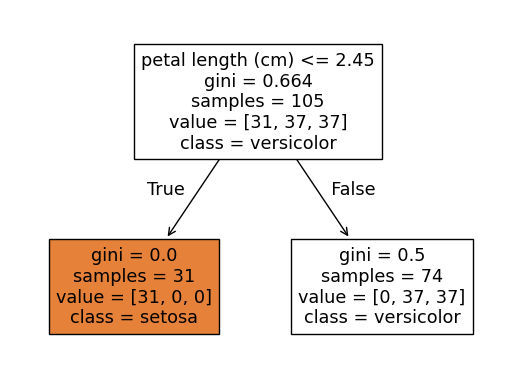

Decision Tree #2 Accuracy: 0.7555555555555555


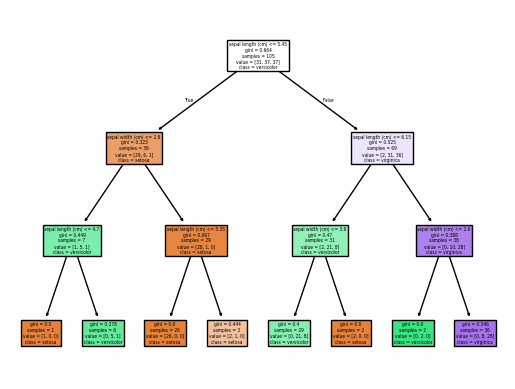

Decision Tree #3 Accuracy: 0.9777777777777777


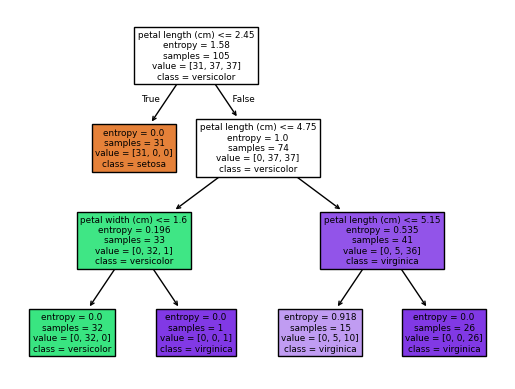

In [17]:
# Evaluate Task 2.1
### DO NOT CHANGE THE CODE BELOW ###
plot_tree(dt1, feature_names=feature_names, class_names=target_names, filled = True)
print("Decision Tree #1 Accuracy:", accuracy_score(y_test, y_pred1))
plt.show()
plot_tree(dt2, feature_names=feature_names[0:2], class_names=target_names, filled = True)
print("Decision Tree #2 Accuracy:", accuracy_score(y_test, y_pred2))
plt.show()
plot_tree(dt3, feature_names=feature_names, class_names=target_names, filled = True)
print("Decision Tree #3 Accuracy:", accuracy_score(y_test, y_pred3))
plt.show()

**Expected Output**:
|&nbsp;|&nbsp;|
|--|--|
|**Decision Tree #1 Accuracy**:| 0.7111111111111111|
|**Decision Tree #2 Accuracy**:| 0.7555555555555555 |
|**Decision Tree #3 Accuracy**:| 0.9777777777777777|

<img src="dt1.png"><img src="dt2.png"><img src="dt3.png">

## Task 2.2 Q&A
**8 pts**

### What factors can impact the performance of a decision tree? List at least four.

Answer here: 
- Tree depth can model more complicated data, but can overfit.
- Choice of splitting criterion affects how splits are made, and can be better or worse for certain types of data.
- How many features you choose to use can give diminishing returns for the amount of computation required
- Class imbalance can bias the tree towards larger classes and not properly split the minority classes

## Task 2.3 Bagging Implementation
**6 pts**

**Instruction:**
Implement Bagging with **100** estimators, using only two features (`sepal length (cm)` and `sepal width (cm)`)

In [18]:
# Bagging Implementation
### START YOUR CODE ### 2pts each
bagging = BaggingClassifier(random_state=42,n_estimators=100)
bagging.fit(X_train[:, :2], y_train)
y_pred = bagging.predict(X_test[:, :2])
### START YOUR CODE ###

In [19]:
# Evaluate Task 2.3
### DO NOT CHANGE THE CODE BELOW ###
print("Bagging Accuracy:", accuracy_score(y_test, y_pred))

Bagging Accuracy: 0.6888888888888889


## Expected output: 
Bagging Accuracy: 0.6888888888888889

## Task 2.4 Random Forest Implementation
**6 pts**

**Instruction:**
Implement Random Forest with **10** estimators, using only two features (`sepal length (cm)` and `sepal width (cm)`)

In [20]:
# Random Forest Implementation
### START YOUR CODE ### 2pts each
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train[:, :2], y_train)
y_pred = rf.predict(X_test[:, :2])
### START YOUR CODE ###

In [21]:
# Evaluate Task 2.4
### DO NOT CHANGE THE CODE BELOW ###
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))

Random Forest Accuracy: 0.7333333333333333


## Expected output: 
Random Forest Accuracy: 0.7333333333333333

## Section 3: *K*-means clustering algorithm on image data

**40pts**

In this assignment, you will practice implementing K-means clustering, and then apply it on a subset of sign language dataset.

The `PCA` module provided by `sklearn` package will be used for pre-clustering analysis and post-clustering visualization. You can install `sklearn` by running the following command in terminal:

```
!pip install scikit-learn
```
This section includes the following coding tasks:
- Task 3.1 (3 pts): PCA
- Task 3.2 (4 pts): Initialize centroids
- Task 3.3 (8 pts): Compute distance between data points and centroids
- Task 3.4 (7 pts): Find the closest centroid for each data point
- Task 3.5 (8 pts): Update centroids
- Task 3.6 (8 pts): Integrated model
- Task 3.7 (2 pts): Visualize clustering result using PCA

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

np.random.seed(1)
%matplotlib inline

## Load data

Load data and preprocess.

In [23]:
X_all = np.load(open('X_train.npy', 'rb'))

X1 = X_all[:163, :]
X2 = X_all[163:327, :]
X3 = X_all[327:491, :]

X = np.concatenate((X1, X2, X3), axis=0)
X = np.transpose(X, (1,2,3,0)).reshape(-1, X.shape[0])
print('Shape of X:', X.shape)

Shape of X: (4096, 491)


## Task 3.1 PCA

**3 points**

First, we reduce and dimension of the original data to 2, and plot it. The goal of this step is to have some clues of what $k$ values to use, i.e., the number of clusters.

We know that image data of 3 classes are selected, but we use them as if they are unlabelled. Judging from the 2-D plot, there are quite amount of outliers in data, and choosing $k=3$ may well group those outliers into a cluster, instead of grouping into the correct classes. For this we will find out at the last step.

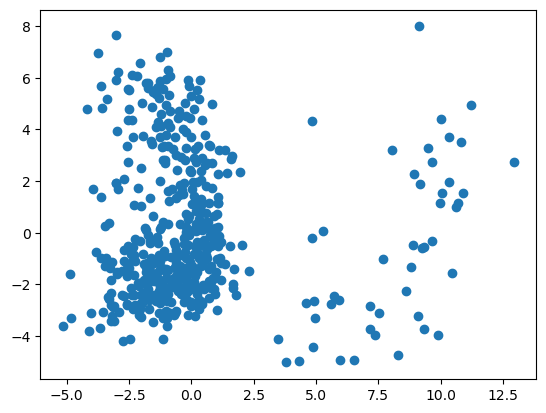

In [24]:
pca = PCA(n_components=2) # 1pt
pca.fit(X.T)
## Todo: Get transformed X values 2pts
X_proj = pca.transform(X.T) 

# Plot
fig = plt.figure()
plt.scatter(X_proj[:,0], X_proj[:,1])
plt.show()

### Expected output
<img src="pca1.png">


## Task 3.2 Initialize centroids
**4 pts**

The first step of k-means is to randomly initialize a set of centroids. To accomplish this, we simply select $k$ out of the $m$ data points randomly.

**Instructions:**
- Data are stored in columns in `X`. We draw `k` random columns out of it by calling `numpy.random.choice()`. Notice that use the argument `replace=False` is important. Otherwise, it is possible to sample repeated points.
- The returned `centroids` are in shape (n, k).

In [29]:
# Initialize centroids
def init_centroids(X, k):
    """
    Args:
    X -- data, shape (n, m)
    k -- number of clusters
    
    Return:
    centroids -- k randomly picked data points as initial centroids, shape (n, k)
    """
    assert(k > 1)
    np.random.seed(1)
    
    ### START YOUR CODE ###
    centroids = X[:,np.random.choice(X.shape[1], size=k,replace=False,)]
    ### END YOUR CODE ###
    
    return centroids

In [30]:
# Evaluate Task 3.2
### DO NOT CHANGE THE CODE BELOW ###
np.random.seed(1)
X_tmp = np.random.randn(4, 10)
c = init_centroids(X_tmp, k=3)

print('Shape of centroids:', c.shape)
print('centroids:', c)

c_expanded = np.expand_dims(c, axis=1)

Shape of centroids: (4, 3)
centroids: [[-0.52817175 -0.24937038  1.74481176]
 [-0.3224172   0.58281521 -0.17242821]
 [ 0.90159072  0.53035547 -0.12289023]
 [-0.6871727   0.74204416 -1.11731035]]


### Expected output
|&nbsp;|&nbsp;|
|--|--|
**Shape of centroids:**(4, 3)
**centroids:**[[-0.52817175 -0.24937038  1.74481176]<br>[-0.3224172   0.58281521 -0.17242821]<br>[ 0.90159072  0.53035547 -0.12289023]]<br>[-0.6871727   0.74204416 -1.11731035]


## Task 3.3 Compute distance between data points and centroids
**8 points**

Next, we need to compute the distances between data points and centroids. More concretely, for each data point `X[:,i]`, we need to compute its distance from the $k$ centroids, i.e., `centroids[:, j]` ($j=1,2,\dots,k$). We will store the computed distances in a $k\times m$ array, in which the element at position $(j, i)$ is the distance between `X[:,i]` and `centroids[:,j]`. The distance we talk about here is Euclidean distance.

There are multiple ways of implementing this computation. The most efficient way is as follows:
- First, expand `centroids` by adding one demension to it, so that its shape changes from (n, k) to (n, 1, k). This can be done by calling `np.expand_dims()`.
- Second, transpose `X` and `centroids_expanded`. The former has shape (m, n) and the latter has shape (k, 1, n). Then the subtraction `S = X.T - centroids_expanded.T` will be in shape (k, m, n). For why it is the case, read the documentation about the broadcasting mechanism of numpy __[here](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.broadcast.html)__. 
Next, following the definition of Euclidean distance, we need to:
    - Compute `S**2`, which is in shape (k, m, n).
    - Sum over `S**2` along `axis=2`, which eliminate the last dimension.
    - Apply `numpy.sqrt()` to `S**2`, resulting in an array of shape (k, m), which gives the Euclidean distances.

If you found the above method hard to follow, you can also use an explicit for loop to do the computation.
- You create an empty array `distances` of shape (k, m).
- Then you use a for loop, `for j in range(k):`, and in each step, you compute `S = X - centroids[:,j]` followed by `S**2`, `numpy.sum()`, and `numpy.sqrt()` to get the Euclidean distance, which is stored in a (1,m) array `d`. Then you copy `d` back to the `j`th row of `distances`.

In [31]:
# Compute distances
def compute_distances(X, centroids):
    """
    Args:
    X -- data, shape (n, m)
    centroids -- shape (n, k)
    
    Return:
    distances -- shape (k, m)
    """
    ### START YOUR CODE ### 4 pts each
    centroids_expanded = np.expand_dims(centroids,1)
    S = X.T - centroids_expanded.T
    distances = np.sqrt(np.sum(S**2, axis=2))
    ### END YOUR CODE ###
    
    return distances

In [32]:
# Evaluate Task 3.3
### DO NOT CHANGE THE CODE BELOW ###
np.random.seed(1)
X_tmp = np.random.randn(4, 5)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
print('Distances:', dists)

Distances: [[3.19996571 3.13120276 0.         1.52120576 2.54127667]
 [5.88553536 0.         3.13120276 2.25851302 4.11463616]]


### Expected output

**Distances:**[[3.19996571 3.13120276 0.         1.52120576 2.54127667]<br>[5.88553536 0.         3.13120276 2.25851302 4.11463616]]


## Task 3.4 Find the closest centroid for each data point
**7 pts**

Given the distances computed, we can find the closest centroid for each data point. We store this information in a $1\times m$ array, and each element is the index of the closest centroid, i.e., an integer ranging from $0$ to $k-1$.

**Instructions:**
- You can apply `numpy.argmin()` on the `distances` computed in previous step as input, and a proper `axis` argument.

In [33]:
# Find the closest centroid for each data point
def cloeset_centroid(distances):
    """
    Args:
    distances -- numpy array of shape (k, m), output of compute_distances()
    
    Return:
    indices -- numpy array of shape (1, m)
    """
    ### START YOUR CODE ###
    indices = np.argmin(distances, axis=0)
    ### END YOUR CODE ###
    
    return indices

In [34]:
# Evaluate Task 3.4
### DO NOT CHANGE THE CODE BELOW ###
np.random.seed(1)
X_tmp = np.random.randn(4, 5)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
closest_indices = cloeset_centroid(dists)

print('Indices of the cloest centroids:', closest_indices)

Indices of the cloest centroids: [0 1 0 0 0]


### Expected output

**Indices of the cloest centroids:**[0 1 0 0 0]

## Task 3.5 Update centroids
**8 pts**

Given the indices of closest centroid for each data point, you need to update the centroids by computing the average positions of the data points belonging to each cluster ($1,2,\dots,k$).

**Instructions:**
- Because `closest_indices` (output of `closes_centroid()`) is of shape (1, m), you can access the data points whose closest centroid is `j` by using the slice `X[:, closest_indices==j]`.
- Pay attention to the dimension of `new_centroids` computed, and it needs to be the same as `centroids`.

In [44]:
# Update centroids
def update_centroids(X, closest_indices, centroids):
    """
    Args:
    X -- data, shape (n, m)
    cloesest_indices -- output of closest_centroid()
    centroids -- old centroids positions
    
    Return:
    new_centroids -- new centroids positions, shape (n, k)
    """
    ### START YOUR CODE ### 
    new_centroids = np.zeros(centroids.shape)
    k = centroids.shape[1]
    for j in range(k):
        points = X[:, closest_indices == j]
        new_centroids[:, j] = np.mean(points, axis=1)

    ### END YOUR CODE ###
    
    assert(centroids.shape == new_centroids.shape)
    
    return new_centroids

In [45]:
# Evaluate Task 3.5
### DO NOT CHANGE THE CODE BELOW ###
np.random.seed(1)
X_tmp = np.random.randn(4, 5)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
closest_indices = cloeset_centroid(dists)
new_c = update_centroids(X_tmp, closest_indices, c)

print('New centroids:', new_c)

New centroids: [[ 0.22215315 -0.61175641]
 [-0.74826922  1.74481176]
 [ 0.47235146 -2.06014071]
 [-0.33818018 -0.17242821]]


### Expected output
|&nbsp;|&nbsp;|
|--|--|
**New centroids:**[[ 0.22215315 -0.61175641]<br>[-0.74826922  1.74481176]<br>[ 0.47235146 -2.06014071]<br>[-0.33818018 -0.17242821]]

## Task 3.6 Integrated model
**8 pts**

Finally, we combine all the previous steps into one model. We repeatedly find the closest centroid for each data points, and then update the centroids, until the centroids no longer change. The final stable `closest_indices` is then the clustering result.

In [46]:
# K-means
def kmeans(X, k):
    """
    Args:
    X -- data, shape (n, m)
    k -- number of clusters
    
    Return:
    closest_indices -- final assignment of clusters to each data point, shape (1, m)
    centroids -- final positions of centroids
    """
    ### START YOUR CODE ### 2pts
    centroids = init_centroids(X, k)
    ### END YOUR CODE ###
    
    old_centroids = None ## this is not a todo
    while not np.array_equal(old_centroids, centroids):
        # Backup centroids
        old_centroids = np.copy(centroids)
        
        ### START YOUR CODE ### 2pts each
        # Compute distances
        distances = compute_distances(X,centroids)
        
        # Find cloeset centroid
        closest_indices = cloeset_centroid(distances)
        
        # Update centroids
        centroids = update_centroids(X,closest_indices,centroids)
        ### END YOUR CODE ###
    
    return closest_indices, centroids

In [47]:
# Evaluate Task 3.6
### DO NOT CHANGE THE CODE BELOW ###
closest_indices, centroids = kmeans(X, 3)

print('closest_indices[:10]', closest_indices[:10])
print('closest_indices[70:80]', closest_indices[70:80])
print('closest_indices[140:150]', closest_indices[140:150])
print('closest_indices[210:220]', closest_indices[210:220])

closest_indices[:10] [1 1 0 0 1 1 1 1 1 0]
closest_indices[70:80] [1 1 1 1 1 1 1 1 1 1]
closest_indices[140:150] [1 1 1 1 1 1 1 1 1 0]
closest_indices[210:220] [2 1 1 1 2 2 2 2 2 2]


### Expected output
|&nbsp;|&nbsp;|
|--|--|
**closest_indices[:10]**[1 1 0 0 1 1 1 1 1 0]
**closest_indices[70:80]**[1 1 1 1 1 1 1 1 1 1]
**closest_indices[140:150]**[1 1 1 1 1 1 1 1 1 0]
**closest_indices[210:220]**[2 1 1 1 2 2 2 2 2 2]


## Task 3.7 Visualize clustering result using PCA

**2pts**


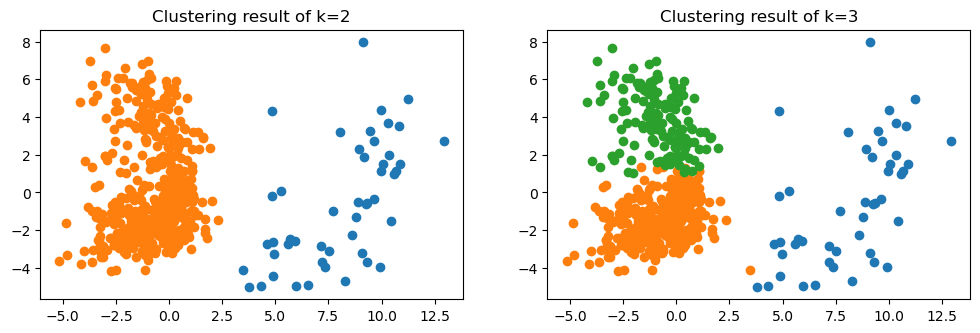

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None) #1pt
pca.fit(X.T)
X_proj = pca.transform(X.T)  #1pt

# Cluster and 
fig = plt.figure(figsize=(12, 3.5))

closest_indices, centroids = kmeans(X, 2)
fig.add_subplot(1, 2, 1)
plt.scatter(X_proj[closest_indices==0, 0], X_proj[closest_indices==0, 1])
plt.scatter(X_proj[closest_indices==1, 0], X_proj[closest_indices==1, 1])
plt.scatter(X_proj[closest_indices==2, 0], X_proj[closest_indices==2, 1])
plt.title('Clustering result of k=2')

closest_indices, centroids = kmeans(X, 3)
fig.add_subplot(1, 2, 2)
plt.scatter(X_proj[closest_indices==0, 0], X_proj[closest_indices==0, 1])
plt.scatter(X_proj[closest_indices==1, 0], X_proj[closest_indices==1, 1])
plt.scatter(X_proj[closest_indices==2, 0], X_proj[closest_indices==2, 1])
plt.scatter(X_proj[closest_indices==3, 0], X_proj[closest_indices==3, 1])
plt.title('Clustering result of k=3')

plt.show()

### Expected output
<img src="kmean.png" style="width:800px;height:300px;">
